# Quality control

Manual thresholds for cell exclusion are applied using the scanpy framework.

# 0. Loading the libraries

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text
from anndata._warnings import ImplicitModificationWarning
warnings.simplefilter(action='ignore', category=ImplicitModificationWarning)

import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [3]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 108))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
sc.settings.verbosity = 3
plt.rcParams['figure.figsize']=(8,8) #rescale figures
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font) #set the font

In [5]:
# Set up constants
folder_path = "../data/BL_new/"
sample_strings = ['NAIVE_0h-1','NAIVE_0h-2','DMSO_2h','DMSO_24h','DMSO_48h','DMSO_d7','N6_2h','N6_24h','N6_48h','N6_d7']
file_base = "/counts_filtered/"
file_h5ad = "adata.h5ad"
save_folder = "figures/"
objects_folder = "saved_objects/"
sc.settings.figdir = './'+save_folder

# 1. Reading in the data

In [6]:
# Data set load & annotation
def open_sample(name):

    #Parse Filenames
    filepath = folder_path+name+file_base+file_h5ad
    #Load data
    adata = sc.read(filepath)

    #Annotate data
    adata.obs['sample'] = [name]*adata.n_obs
    adata.obs['cond'] = [name.split("_")[0]]*adata.n_obs
    adata.obs['tp'] = [(name.split("-")[0]).split("_")[1]]*adata.n_obs

    return adata

In [7]:
# Load the first data set
adata = open_sample(sample_strings[0])

# Loop to load the rest of data sets
for i in range(1, len(sample_strings)):

    # Load the following data set
    adata_tmp = open_sample(sample_strings[i])

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    
    adata.obs.drop(columns=['sample_id'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

adata.X = adata.X.toarray()

cat_type = CategoricalDtype(categories=sample_strings,ordered=True)
new_obs = adata.obs['sample'].astype(cat_type)
adata.obs['sample'] = new_obs

In [8]:
# Make gene names unique to set as index

seen = set()
unique_genes = []

for item in adata.var["gene_name"]:
    fudge = 1
    newitem = item

    while newitem in seen:
        fudge += 1
        newitem = "{}_{}".format(item, fudge)

    unique_genes.append(newitem)
    seen.add(newitem)

adata.var["unique_genes"] = unique_genes
adata.var = adata.var.set_index("unique_genes")

In [9]:
txt = '*--- Initial cell counts (before QC) ---*\n\n'

# Checking the size of each cell subset
txt += str(adata.obs['cond'].value_counts()) + '\n\n'
txt += str(adata.obs['tp'].value_counts()) + '\n\n'
txt += str(adata.obs['sample'].value_counts()) + '\n\n'

# Checking the total size of the data set
txt += 'We have {:d} cells and {:d} genes in the dataset.'.format(adata.shape[0], adata.shape[1])

print(txt)

# Save to .txt
with open(save_folder+'/initial_cell_counts.txt', 'w') as f:
    f.write(txt)
    f.close()

*--- Initial cell counts (before QC) ---*

DMSO     70058
N6       24867
NAIVE     9260
Name: cond, dtype: int64

48h    64128
d7     12170
24h     9888
0h      9260
2h      8739
Name: tp, dtype: int64

DMSO_48h      56332
N6_d7          8367
N6_48h         7796
NAIVE_0h-2     5932
DMSO_2h        5284
N6_24h         5249
DMSO_24h       4639
DMSO_d7        3803
N6_2h          3455
NAIVE_0h-1     3328
Name: sample, dtype: int64

We have 104185 cells and 55421 genes in the dataset.


# 2. Quality control

In [10]:
# Compute QC covariates

adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)
adata.obs['log_genes'] = np.log10(adata.obs['n_genes'])

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var['gene_name']]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

Pre-filter DMSO_48h

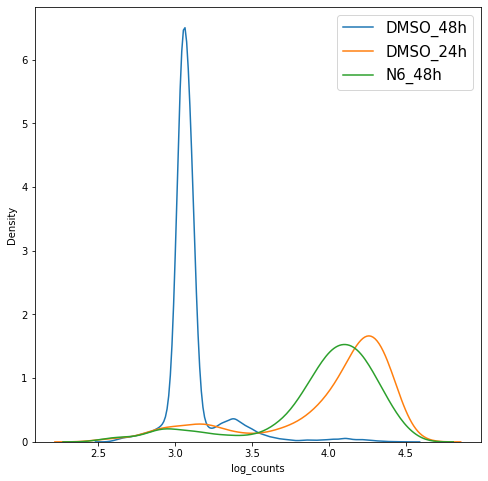

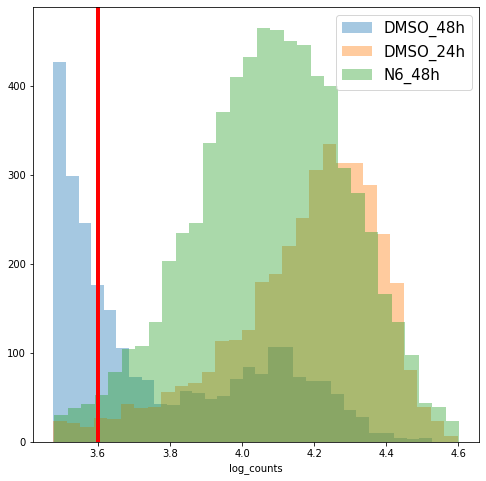

In [16]:
#Plot distribution of counts
p = sb.kdeplot(adata[adata.obs['sample']=="DMSO_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>300)], label='DMSO_48h')
p = sb.kdeplot(adata[adata.obs['sample']=="DMSO_24h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>300)], label='DMSO_24h')
p = sb.kdeplot(adata[adata.obs['sample']=="N6_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>300)], label='N6_48h')
plt.legend(prop={'size': 15})
plt.show()
p.figure.savefig(save_folder+"kde_log_counts_DMSO48h.png")

#Plot histograms of counts
p = sb.distplot(adata[adata.obs['sample']=="DMSO_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>3000)], kde=False, hist=True, bins = 30, label='DMSO_48h')
p = sb.distplot(adata[adata.obs['sample']=="DMSO_24h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>3000)], kde=False, hist=True, bins = 30, label='DMSO_24h')
p = sb.distplot(adata[adata.obs['sample']=="N6_48h"].obs['log_counts'][(adata.obs['n_counts']<40000) & (adata.obs['n_counts']>3000)], kde=False, hist=True, bins = 30, label='N6_48h')
p.axvline(3.6, color='red', lw=4)
plt.legend(prop={'size': 15})
plt.show()
p.figure.savefig(save_folder+"hist_log_counts_DMSO48h.png")

computing PCA
    with n_comps=20
    finished (0:00:55)
computing neighbors
    using 'X_pca' with n_pcs = 20


2022-06-24 13:35:38.987908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib:
2022-06-24 13:35:38.988003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:50)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:17)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


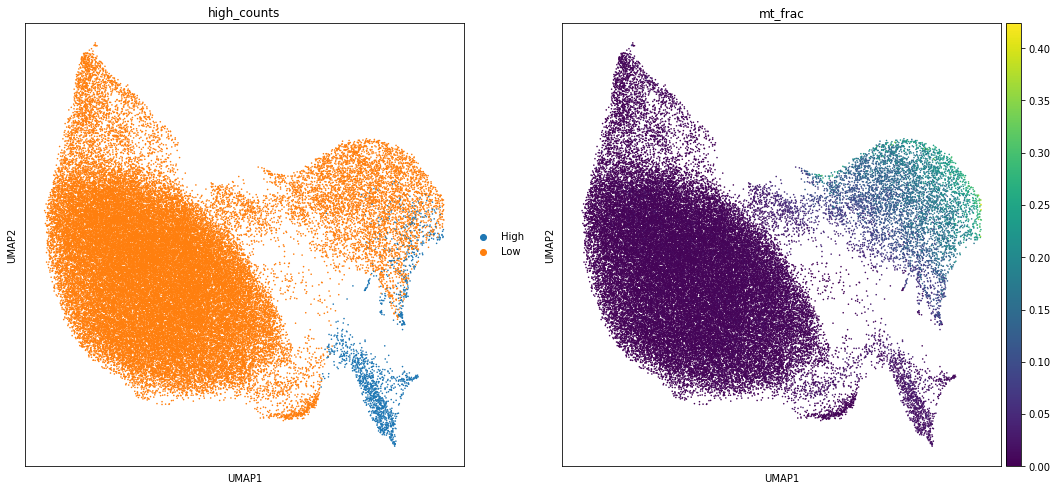

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:17)


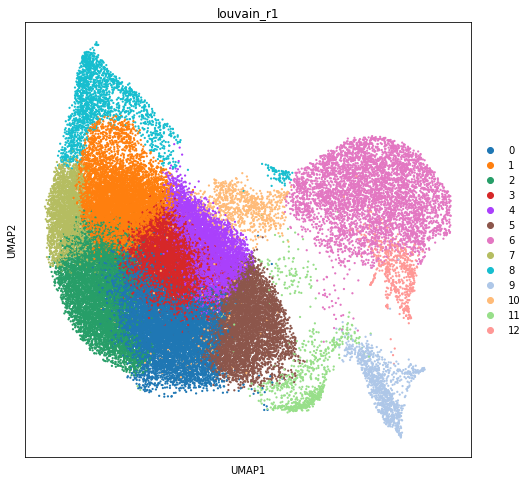

0     10066
1      7900
2      7310
3      7154
4      5686
5      5519
6      4739
7      2579
8      1963
9      1029
10      983
11      839
12      565
Name: louvain_r1, dtype: int64


In [18]:
# Represent the cells of DMSO_48h on a UMAP plot

adata_dmso = adata[adata.obs['sample'] == "DMSO_48h"].copy()
sc.pp.pca(adata_dmso, n_comps=20, use_highly_variable=False, svd_solver='arpack')

sc.pp.neighbors(adata_dmso)
sc.tl.umap(adata_dmso, random_state=0)

adata_dmso.obs['high_counts'] = ["High" if e > 3.6 else "Low" for e in adata_dmso.obs['log_counts']]
sc.pl.umap(adata_dmso, color=['high_counts', 'mt_frac'], size = 10, save = "_DMSO-48h_highcounts_mtfrac.png")

# Perform a clustering
sc.tl.louvain(adata_dmso, resolution=1, key_added='louvain_r1', random_state=0)
sc.pl.umap(adata_dmso, color=['louvain_r1'], size = 20, save = "DMSO-48h_clusters.png")
print(adata_dmso.obs['louvain_r1'].value_counts())

In [20]:
adata_dmso = adata_dmso[adata_dmso.obs['louvain_r1'].isin(['6', '9', '10', '11'])]
adata = adata[(adata.obs_names.isin(adata_dmso.obs_names)) | (adata.obs['sample'] != 'DMSO_48h')]
adata.obs['sample'].value_counts()

N6_d7         8367
N6_48h        7796
DMSO_48h      7590
NAIVE_0h-2    5932
DMSO_2h       5284
N6_24h        5249
DMSO_24h      4639
DMSO_d7       3803
N6_2h         3455
NAIVE_0h-1    3328
Name: sample, dtype: int64

In [21]:
#Print the samples in order
print(adata.obs['sample'].cat.categories.tolist())

#Manually define the thresholds for this ordered list of samples
thresholds = [
    [[2000, 8000], [900, 3000], 6],
    [[2000, 9000], [900, 3000], 4],
    [[2000, 10000], [1000, 3000], 5],
    [[6000, 30000], [2000, 5000], 3],
    [[6000, 20000], [1500, 4300], 5],
    [[4000, 30000], [1300, 6000], 7],
    [[2300, 10000], [900, 3000], 4],
    [[2300, 33000], [1300, 5300], 3],
    [[4000, 30000], [1300, 5300], 4],
    [[2300, 10000], [800, 4000], 5],
]

['NAIVE_0h-1', 'NAIVE_0h-2', 'DMSO_2h', 'DMSO_24h', 'DMSO_48h', 'DMSO_d7', 'N6_2h', 'N6_24h', 'N6_48h', 'N6_d7']


NAIVE_0h-1
NAIVE_0h-2
DMSO_2h
DMSO_24h
DMSO_48h
DMSO_d7
N6_2h
N6_24h
N6_48h
N6_d7


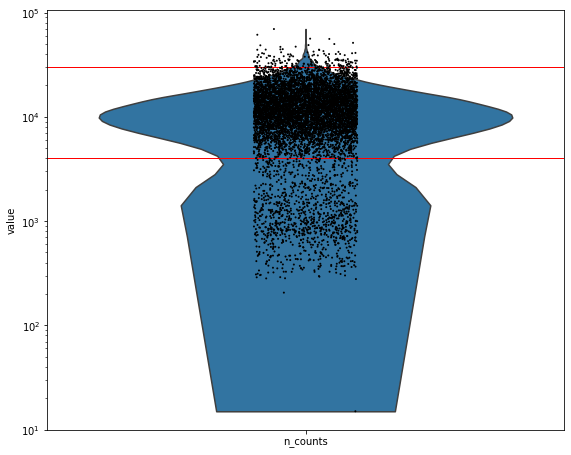

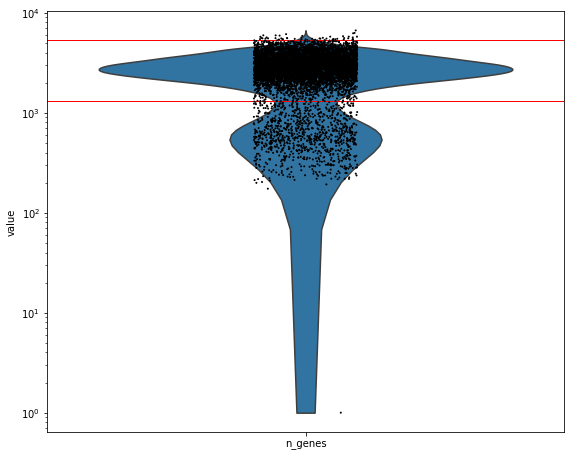

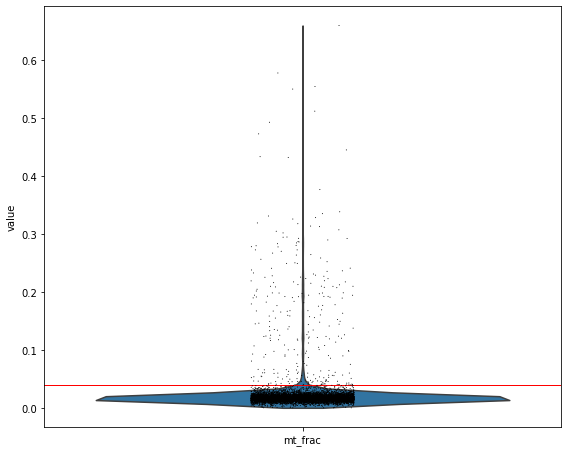

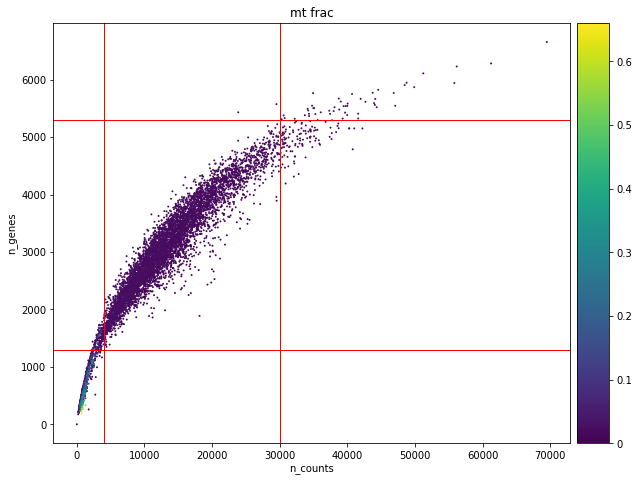

In [23]:
# Plot QC metrics
samples = adata.obs['sample'].cat.categories
for i in range(len(samples)):
    print(samples[i])

    # counts and genes plot
    t1 = sc.pl.violin(adata[adata.obs['sample']==samples[i]], 'n_counts', size=2, log=True, cut=0, ax=None, show=False)
    t1.axhline(thresholds[i][0][0], color='red', lw=1)
    t1.axhline(thresholds[i][0][1], color='red', lw=1)
    t2 = sc.pl.violin(adata[adata.obs['sample']==samples[i]], 'n_genes', size=2, log=True, cut=0, ax=None, show=False)
    t2.axhline(thresholds[i][1][0], color='red', lw=1)
    t2.axhline(thresholds[i][1][1], color='red', lw=1)

    # mito plot
    t3 = sc.pl.violin(adata[adata.obs['sample']==samples[i]], 'mt_frac', ax=None, show=False)
    t3.axhline(thresholds[i][2]/100, color='red', lw=1)

    # combined plot
    t5 = sc.pl.scatter(adata[adata.obs['sample']==samples[i]], 'n_counts', 'n_genes', color='mt_frac', ax=None, show=False)
    t5.axvline(thresholds[i][0][0], color='red', lw=1)
    t5.axvline(thresholds[i][0][1], color='red', lw=1)
    t5.axhline(thresholds[i][1][0], color='red', lw=1)
    t5.axhline(thresholds[i][1][1], color='red', lw=1)

    # save figures
    t1.figure.savefig(save_folder+samples[i]+"_QC_ncounts.png")
    t2.figure.savefig(save_folder+samples[i]+"_QC_ngenes.png")
    t3.figure.savefig(save_folder+samples[i]+"_QC_mtfrac.png")
    t5.figure.savefig(save_folder+samples[i]+"_QC_combined.png")

    # plot one sample as an example
    if i != 8:
        plt.close(t1.figure)
        plt.close(t2.figure)
        plt.close(t3.figure)
        plt.close(t5.figure)
    

In [25]:
# Apply QC thresholds

for i in range(len(samples)):
    adata = adata[(adata.obs['sample'] != samples[i]) | (
        (adata.obs['n_counts'] > thresholds[i][0][0]) & 
        (adata.obs['n_counts'] < thresholds[i][0][1]) & 
        (adata.obs['n_genes'] > thresholds[i][1][0]) & 
        (adata.obs['n_genes'] < thresholds[i][1][1]) & 
        (adata.obs['mt_frac'] < thresholds[i][2]/100)
        )]

In [26]:
txt = '*--- Filtered cell counts (after QC) ---*\n\n'

# Annotate the data sets
txt += str(adata.obs['cond'].value_counts()) + '\n\n'
txt += str(adata.obs['tp'].value_counts()) + '\n\n'
txt += str(adata.obs['sample'].value_counts()) + '\n\n'

# Checking the total size of the data set
txt += 'We have {:d} cells and {:d} genes in the dataset.'.format(adata.shape[0], adata.shape[1])

print(txt)

# Save to .txt
with open(save_folder+'/filtered_cell_counts.txt', 'w') as f:
    f.write(txt)
    f.close()

*--- Filtered cell counts (after QC) ---*

N6       19361
DMSO     11238
NAIVE     6826
Name: cond, dtype: int64

d7     8834
24h    8127
48h    7418
0h     6826
2h     6220
Name: tp, dtype: int64

N6_48h        6492
N6_d7         6124
N6_24h        4653
NAIVE_0h-2    4415
DMSO_2h       4128
DMSO_24h      3474
DMSO_d7       2710
NAIVE_0h-1    2411
N6_2h         2092
DMSO_48h       926
Name: sample, dtype: int64

We have 37425 cells and 55421 genes in the dataset.


In [ ]:
# Exclude genes

adata = adata[:,~adata.var_names.isin(["Gm42418", "AY036118"])] #Technical issues https://doi.org/10.1242/dev.183855

sc.pp.filter_genes(adata, min_cells=50) #Filter out 0 count genes

filtered out 40838 genes that are detected in less than 50 cells


In [ ]:
save_object(adata, objects_folder+'adata_raw.pkl')

# 3. Normalization

In [ ]:
# Load the raw post QC data

with open(objects_folder+'adata_raw.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [ ]:
# Normalize adata

# Save a raw layer
adata.raw = adata

# Logarithmize the data matrix
sc.pp.log1p(adata)

# Compute highly_variable_genes
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)

# Scale the data matrix
sc.pp.scale(adata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
save_object(adata, objects_folder+'adata_norm.pkl')

# 4. Refactor the sample covariate

In [28]:
with open(objects_folder+'adata_norm.pkl', 'rb') as inp:
    adata = pickle.load(inp)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:52)


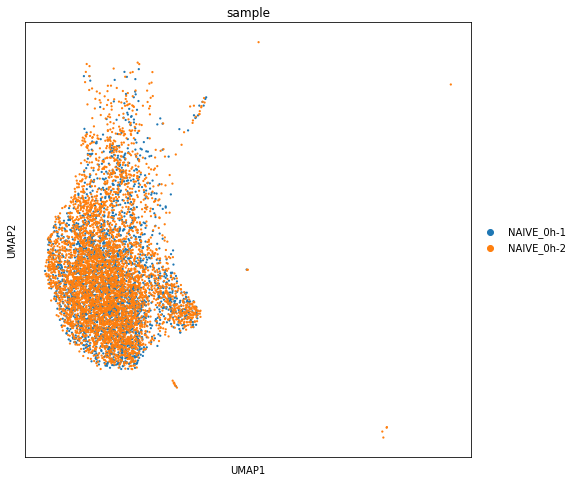

In [30]:
# Compare the two NAÏVE replicates
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata, random_state = 0)
sc.pl.umap(adata[adata.obs['cond'] == 'NAIVE'], color=['sample'], size = 20, save = "_NAIVE_compare.png")

In [ ]:
#Merge NAÏVE replicates and rename samples

obs_save = adata.obs
dictio = {"NAIVE_0h-1": "NAIVE-0h", "NAIVE_0h-2": "NAIVE-0h", "N6_2h": "N6-2h", "N6_24h": "N6-24h", "N6_48h": "N6-48h", 
          "DMSO_2h": "DMSO-2h", "DMSO_24h": "DMSO-24h", "DMSO_48h": "DMSO-48h",
          "N6_d7": "N6-d7", "DMSO_d7": "DMSO-d7"}
cat_type = CategoricalDtype(categories=["NAIVE-0h", "N6-2h", "DMSO-2h", "N6-24h", "DMSO-24h", "N6-48h", "DMSO-48h", "N6-d7", "DMSO-d7"],ordered=True)
new_obs = obs_save['sample'].map(dictio).astype(cat_type)
adata.obs['sample2'] = new_obs

In [ ]:
save_object(adata, objects_folder+'adata_norm.pkl')

# 5. Visualizations

In [32]:
with open(objects_folder+'adata_norm.pkl', 'rb') as inp:
    adata = pickle.load(inp)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:51)


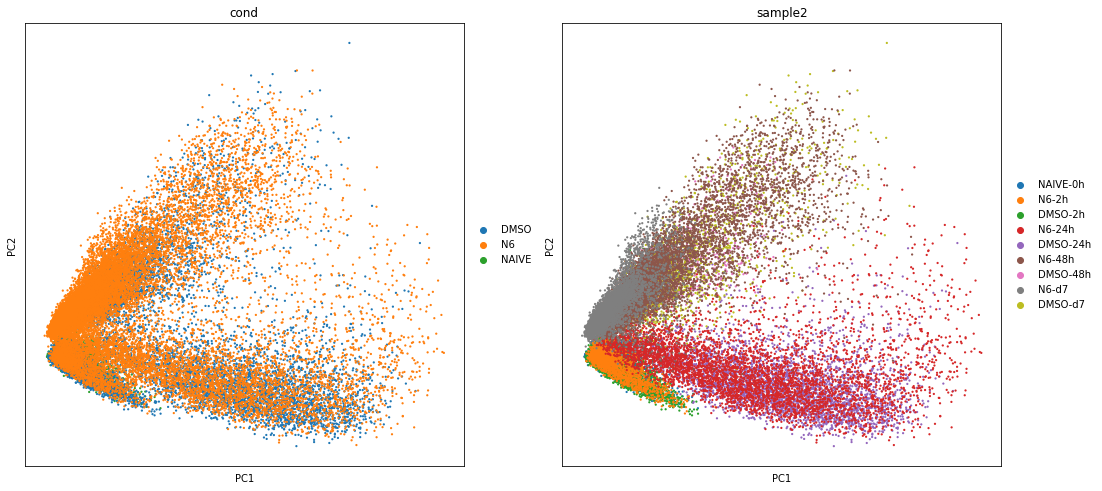

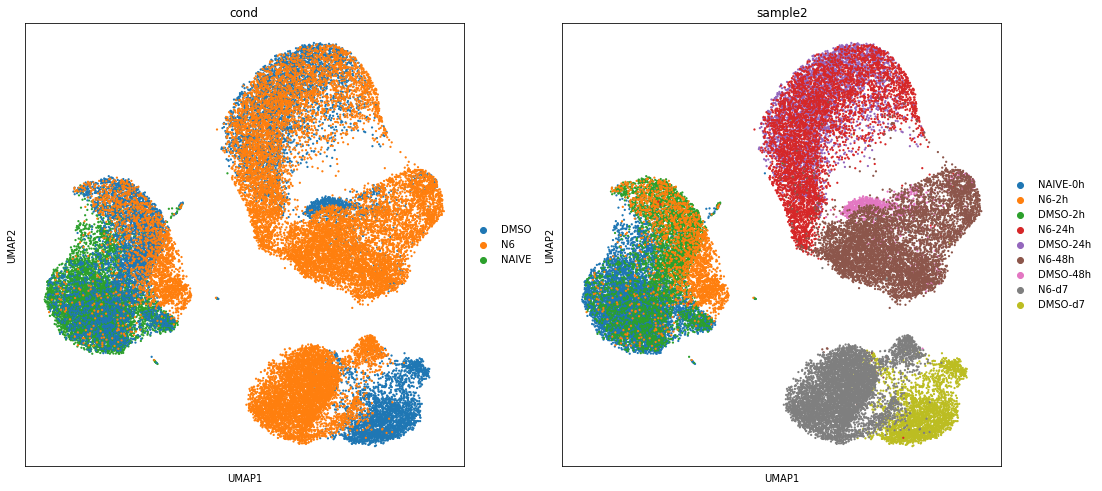

In [34]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack', random_state = 0)
sc.pp.neighbors(adata, random_state = 0)

sc.tl.umap(adata, random_state = 0)

sc.pl.pca_scatter(adata, color=['cond', 'sample2'], size = 20, save = "_pp.png")
sc.pl.umap(adata, color=['cond', 'sample2'], size = 20, save = "_pp.png")

In [ ]:
save_object(adata, objects_folder+'adata_viz.pkl')

# 6. Infer cell cycle phase

In [ ]:
with open(objects_folder+'adata_viz.pkl', 'rb') as inp:
    adata = pickle.load(inp)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    2172 total control genes are used. (0:00:11)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    2259 total control genes are used. (0:00:08)
-->     'phase', cell cycle phase (adata.obs)


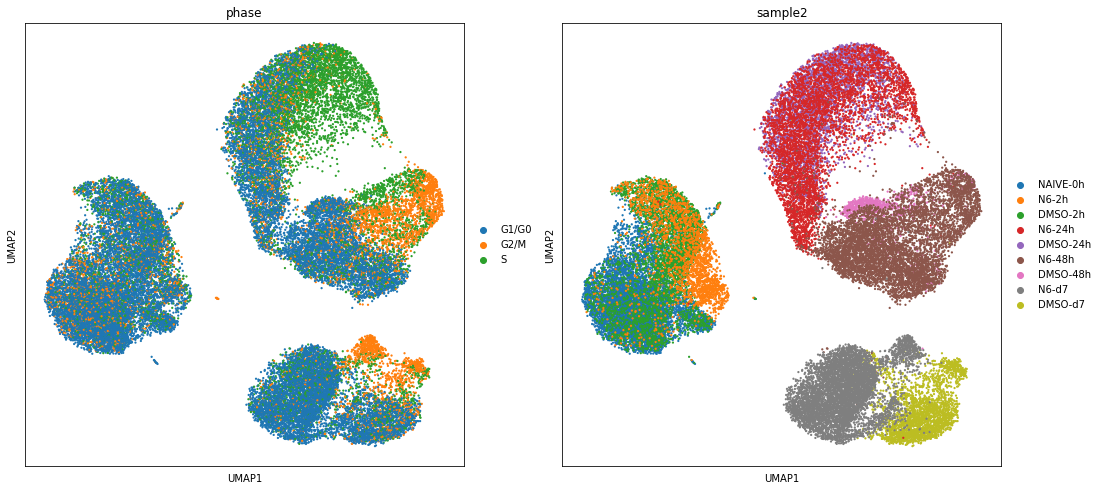

In [36]:
#Open a list of genes associated to cell cycle phases
cc_genes_file = 'files/Macosko_cell_cycle_genes.txt'
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

#Score cell cycle
s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens, use_raw = False, random_state = 0)

#Plot cell cycle phase
def rename_phase(e):
    if e == "G1":
        return "G1/G0"
    elif e == "G2M":
        return "G2/M"
    else:
        return e
adata.obs['phase'] = [rename_phase(e) for e in adata.obs['phase']]
sc.pl.umap(adata, color=['phase', 'sample2'], size = 20, save = "_CC_overlay.png")

# 7. PCA of bulk samples

In [38]:
# Compute bulk averages for each sample

bulkadata = adata.copy()
bulkadata.X = bulkadata.raw.X

bulk = pd.DataFrame(columns=set(adata.obs['sample']))

for samp in set(adata.obs['sample']):
    bulk[samp] = np.mean(bulkadata.X[adata.obs['sample']==samp,:], axis=0)

samp = bulk.columns
bulk = bulk.T

In [39]:
# Standardizing the features
bulk = StandardScaler().fit_transform(bulk)

# Compute PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(bulk)
principalDf = pd.DataFrame(data = principalComponents)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


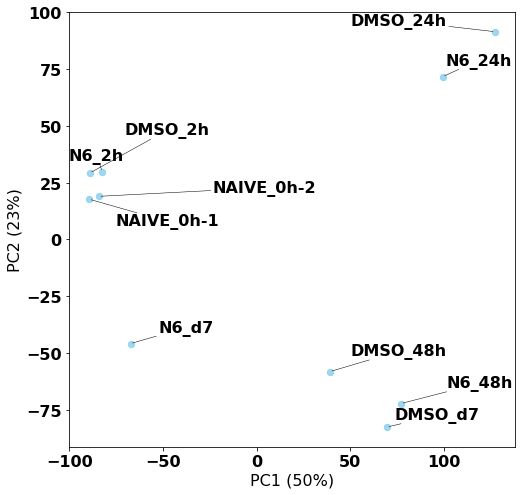

[8.0, 8.0]

In [41]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

# Final dataframe to plot
names = pd.Series(samp)
finalDf = pd.concat([principalDf, pd.Series(samp)], axis = 1)
pc1 = "PC1 ("+str(round(pca.explained_variance_ratio_[0]*100))+"%)"
pc2 = "PC2 ("+str(round(pca.explained_variance_ratio_[1]*100))+"%)"
finalDf.columns = [pc1, pc2, "samp"]

# Basic PCA plot
sb.regplot(data=finalDf, x=pc1, y=pc2, fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':40})

# Adjust text
texts = []
for x, y, s in zip(finalDf[pc1], finalDf[pc2], finalDf.samp):
    texts.append(plt.text(x, y, s))
adjust_text(texts, force_points=0.2, force_text=0.5,
            expand_points=(2, 2), expand_text=(1, 2),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.savefig(save_folder+"PCA_bulk.png", bbox_inches = 'tight')
plt.show()
plt.rcParams['figure.figsize']

# 8. Save the pre-processed object

The *adata* object is saved for later

In [ ]:
adata

AnnData object with n_obs × n_vars = 37425 × 14581
    obs: 'sample', 'cond', 'tp', 'n_counts', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'sample2', 'S_score', 'G2M_score', 'phase'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cond_colors', 'sample2_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [ ]:
save_object(adata, objects_folder+'adata_preprocessed.pkl')